In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
seq_dict = {"601":"CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT", 
            "601RTA":"CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCTACCGCGTTTTAACCGCCAATAGGATTACTTACTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT", 
            "601MF": "CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACACCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTGTCTACTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT",
            "601L": "CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTGTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAG",
            "5S": "CTTCCAGGGATTTATAAGCCGATGACGTCATAACATCCCTGACCCTTTAAATAGCTTAACTTTCATCAAGCAAGAGCCTACGACCATACCATGCTGAATATACCGGTTCTCGTCCGATCACCGAAGTCAAGCAGCATAGGGCTCGGT"  }

nucmethod = "hybrid"

In [3]:
import os 
import sys
from py_analysis.modules.NucFreeEnergy import NucleosomeBreath
from py_analysis.config.custom_types import FreeEnergyResult, NuclBreathingResult
from typing import List
import concurrent.futures
from tqdm import tqdm
import pandas as pd



In [4]:
states = []
for left in range(15):  # Left binding site: 0 to 13
    for right in range(left, 15):  # Right must be ≥ left
        states.append((left, right))

print(f"Total states: {len(states)}")

Total states: 120


In [5]:
states

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (7, 7),
 (7, 8),
 (7, 9),
 (7, 10),
 (7, 11),
 (7, 12),
 (7, 13),
 (7, 14),
 (8, 8),
 (8, 9),
 (8, 10),
 (8, 11),
 (8, 12),
 (8, 13),
 (8, 14),
 (9, 9),
 (9, 10),
 (9, 11),
 (9, 12),
 (9, 13),
 (9, 14),
 (10,

In [6]:
# states

def energy_per_sequence(key, seq, nucmethod:str, bind_sates:List[tuple], hard:bool=False)->  List[NuclBreathingResult]:
    nucleosomebreath = NucleosomeBreath(nuc_method=nucmethod)
    results:List[NuclBreathingResult] = []

    for bind_loc in bind_sates:

        if hard:
            free_energy = nucleosomebreath.calculate_free_energy_hard(seq147=seq,
                                                                    left=bind_loc[0], right=bind_loc[1], id=key)

        else:
            free_energy = nucleosomebreath.calculate_free_energy_soft(seq601=seq, 
                                                                  left=bind_loc[0], right=bind_loc[1], id=key)
            
        res_nucbreath = NuclBreathingResult(
            id=key,
            subid=None,
            sequence=seq,
            leftbind_indx=bind_loc[0],
            rightbind_indx=bind_loc[1],
            F_vals=free_energy
        )
        results.append(res_nucbreath)

    return results

results_all:List[NuclBreathingResult] = []
with concurrent.futures.ProcessPoolExecutor(max_workers=5) as executor:


    futures = [executor.submit(energy_per_sequence, s, seq_dict[s], 'hybrid', states, hard=False) for s in seq_dict.keys()]
    total = len(futures)

    for future in tqdm(concurrent.futures.as_completed(futures), total=total, desc="Processing sequences"):
        energy_array = future.result()
        results_all.extend(energy_array)

Processing sequences:   0%|          | 0/5 [00:00<?, ?it/s]

Using nucleosome method: hybridUsing nucleosome method: hybridUsing nucleosome method: hybridUsing nucleosome method: hybridUsing nucleosome method: hybrid




Using hang DNA method: mdUsing hang DNA method: mdUsing hang DNA method: mdUsing hang DNA method: md
Using hang DNA method: md


Using hang stiffness: FalseUsing hang stiffness: False
Using hang stiffness: False
Using hang stiffness: False
Using hang stiffness: False




Processing sequences: 100%|██████████| 5/5 [01:36<00:00, 19.28s/it]


In [7]:

df_results = pd.DataFrame([result._asdict() for result in results_all])
df_free_energy = df_results['F_vals'].apply(lambda x: x._asdict() if hasattr(x, '_asdict') else x).apply(pd.Series)
df_free_energy = df_free_energy[['F', 'F_entropy', 'F_enthalpy', 'F_freedna']]
df_full = pd.concat([df_results.drop(columns=['F_vals']), df_free_energy], axis=1)


In [8]:
df_full

,id,subid,sequence,leftbind_indx,rightbind_indx,Adsorp_F,F,F_entropy,F_enthalpy,F_freedna
0,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,0,0,0.0,1665.995831,1665.613760,0.382071,1650.286369
1,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,0,1,0.0,1677.816020,1675.122383,2.693637,1650.286369
2,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,0,2,0.0,1697.008048,1688.932436,8.075612,1650.286369
3,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,0,3,0.0,1711.700379,1698.051289,13.649090,1650.286369
4,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,0,4,0.0,1728.474859,1711.772678,16.702181,1650.286369
...,...,...,...,...,...,...,...,...,...,...
595,5S,None,CTTCCAGGGATTTATAAGCCGATGACGTCATAACATCCCTGACCCT...,12,13,0.0,1681.466823,1678.240678,3.226145,1653.292329
596,5S,None,CTTCCAGGGATTTATAAGCCGATGACGTCATAACATCCCTGACCCT...,12,14,0.0,1681.466823,1678.240678,3.226145,1653.292329
597,5S,None,CTTCCAGGGATTTATAAGCCGATGACGTCATAACATCCCTGACCCT...,13,13,0.0,1669.249420,1668.764734,0.484686,1653.292329
598,5S,None,CTTCCAGGGATTTATAAGCCGATGACGTCATAACATCCCTGACCCT...,13,14,0.0,1669.249420,1668.764734,0.484686,1653.292329


In [7]:

df_full["dF"] = df_full["F"] - df_full["F_freedna"]
# df_full["dF"] = df_full["F"] - df_full["F_freedna"]

In [8]:
df_full["left_open"] = df_full["leftbind_indx"]
df_full["right_open"] = df_full["rightbind_indx"].apply(lambda x: 13 - x)


In [9]:
df_full.to_csv("free_energy_results_soft.csv", index=False)

# df_full.to_csv("free_energy_results_hard.csv", index=False)

# Plotting

In [13]:
df_full = pd.read_csv("free_energy_results_soft.csv")
# df_full = pd.read_csv("free_energy_results_hard.csv")

In [14]:
import numpy as np

from py_analysis.utils.plot_2d_heatmaps import plot_probability_heatmaps

from py_analysis.utils.plot_3d import plot_3d_filled_volume

In [15]:

E_ads=5

df_full["Adsorp_F"]= -E_ads*(14-(df_full["left_open"]+df_full["right_open"]))
df_full["dF_total"] = df_full["F_enthalpy"] + df_full["Adsorp_F"]

df_full["df_exp"]= df_full["dF_total"].apply(lambda x: np.exp(-x))
df_full["df_exp_norm"] = df_full.groupby("id")["df_exp"].transform(lambda x: x / x.sum())


/tmp/ipykernel_675615/330202466.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


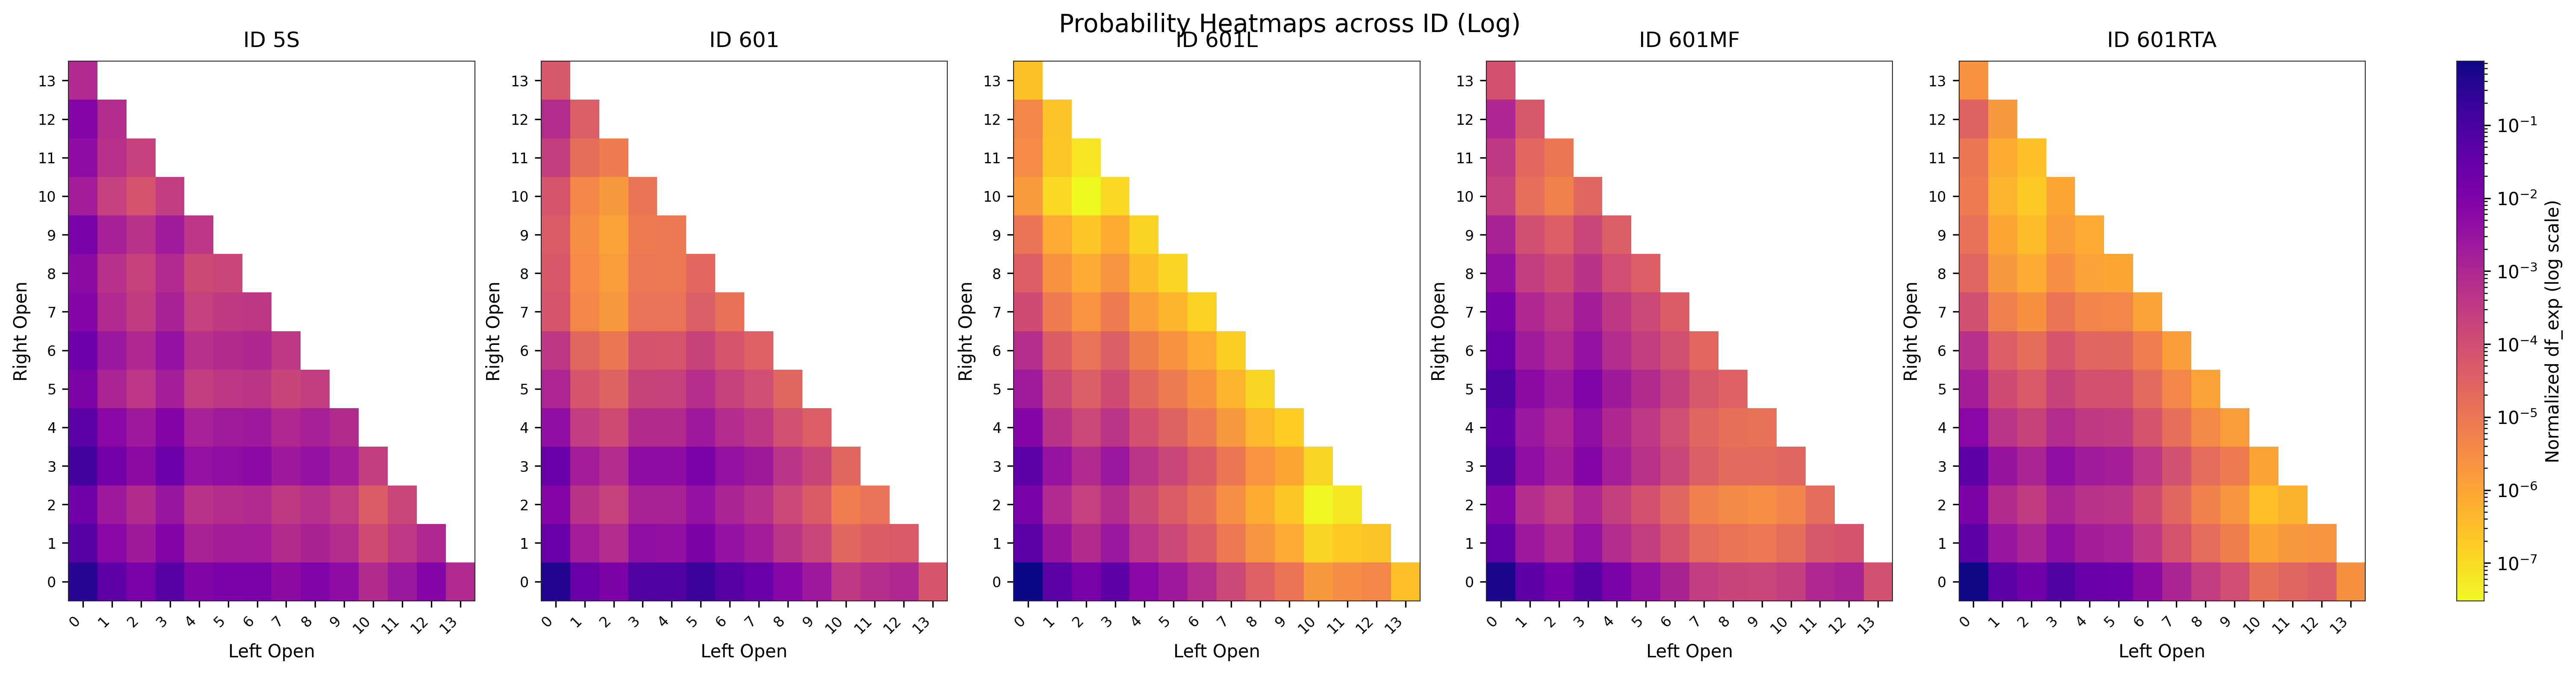

In [16]:
fig, axs = plot_probability_heatmaps(
    df_full,
    value_col='df_exp_norm',
    id_col='id',
    x_col='right_open',
    y_col='left_open',
    xlabel='Left Open',
    ylabel='Right Open',
    log_scale=True,
    colormap='plasma_r',
    figsize=(20, 5),
    suptitle="Probability Heatmaps across ID (Log)", dpi=300, colorbar_label = 'Normalized df_exp (log scale)'
)
fig.show()

In [ ]:
fig2 = plot_3d_filled_volume(
    df_full,
    x_col='left_open', y_col='right_open', z_col='dF_total',
    x_label='Left Opening',
    y_label='Right Opening',
    z_label='ΔF (kT)',
    width=800, height=600,
    title='Free‐Energy Landscapes',
    colorscale='Plasma_r'
)
fig2.show()
